In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import chi2
from scipy.stats import norm
import seaborn as sns
df1=pd.read_csv("/Users/kimizuo/Desktop/QRM-2025-cw1-data-b(1).csv")

In [2]:
#Calculate the negative log return
loss=-np.log(df1["Adj Close"]).diff().dropna().reset_index(drop=True)

In [3]:
#Historical Simulation with 500 windows
result=[]
for i in range(500, len(loss)-1):
    window_losses = loss[i-500:i]
    #Calulate the VaR and ES in the window
    VaR_95 = np.quantile(window_losses, 0.95)
    VaR_99 = np.quantile(window_losses, 0.99)
    ES_95 = window_losses[window_losses >= VaR_95].mean()
    ES_99 = window_losses[window_losses >= VaR_99].mean()
    result.append({"HS_VaR_95": VaR_95,"HS_ES_95": ES_95,"HS_VaR_99": VaR_99,"HS_ES_99": ES_99,
                    "realized_loss": loss[i]})
result = pd.DataFrame(result)


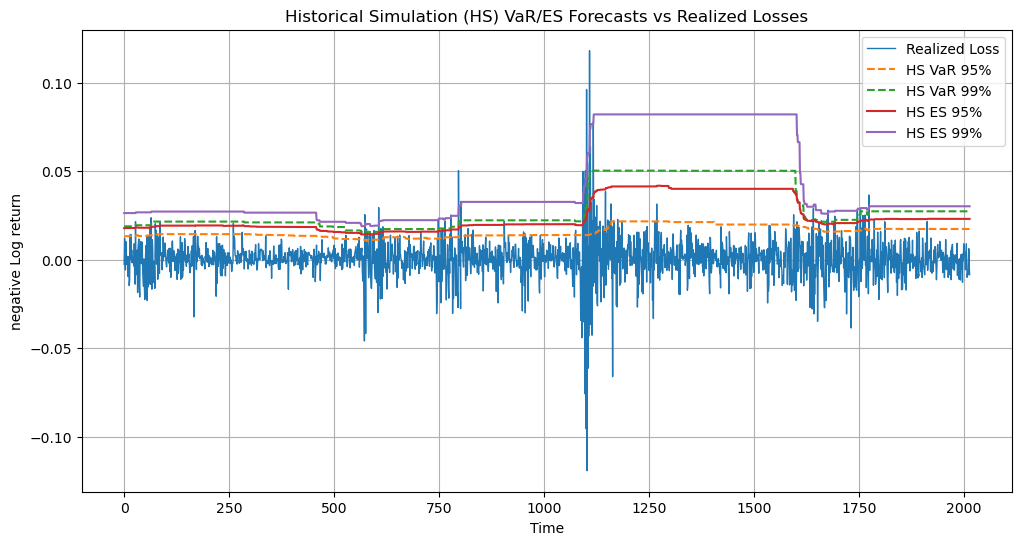

In [4]:
#Plot of results using HS
plt.figure(figsize=(12,6))

# Plot actual realized losses
plt.plot(result.index, result["realized_loss"], label="Realized Loss", linewidth=1)

# Plot HS VaR forecasts
plt.plot(result.index, result["HS_VaR_95"], label="HS VaR 95%", linestyle="--")
plt.plot(result.index, result["HS_VaR_99"], label="HS VaR 99%", linestyle="--")

# Plot HS ES forecasts
plt.plot(result.index, result["HS_ES_95"], label="HS ES 95%", linestyle="-")
plt.plot(result.index, result["HS_ES_99"], label="HS ES 99%", linestyle="-")

plt.title("Historical Simulation (HS) VaR/ES Forecasts vs Realized Losses")
plt.xlabel("Time")
plt.ylabel("negative Log return")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
#Filtered Historical Simulation with EWMA with 500 windows
result1=[]
#Initial estimation of variance
variance=[loss[:500].var()]
residuals=list(loss[:500]/np.sqrt(variance[0]))
for i in range(500, len(loss)-1):
    window_losses = residuals[i-500:i]
    variance.append(0.06*loss[i-1]**2+0.94*variance[-1])
    #The 95% quantile for standardised residual
    z95=np.quantile(window_losses, 0.95)
    #The 99% quantile for standardised residual
    z99=np.quantile(window_losses, 0.99)
    VaR_95 = np.sqrt(variance[-1])*z95
    VaR_99 = np.sqrt(variance[-1])*z99
    ES_95 = np.sqrt(variance[-1])*np.mean([x for x in window_losses if x >= z95])
    ES_99 = np.sqrt(variance[-1])*np.mean([x for x in window_losses if x >= z99])
    #Append the new standardised residual
    residuals.append(loss[i]/np.sqrt(variance[-1]))
    result1.append({"FHS_VaR_95": VaR_95,"FHS_ES_95": ES_95,"FHS_VaR_99": VaR_99,"FHS_ES_99": ES_99,
                    "realized_loss": loss[i]})
result1 = pd.DataFrame(result1)


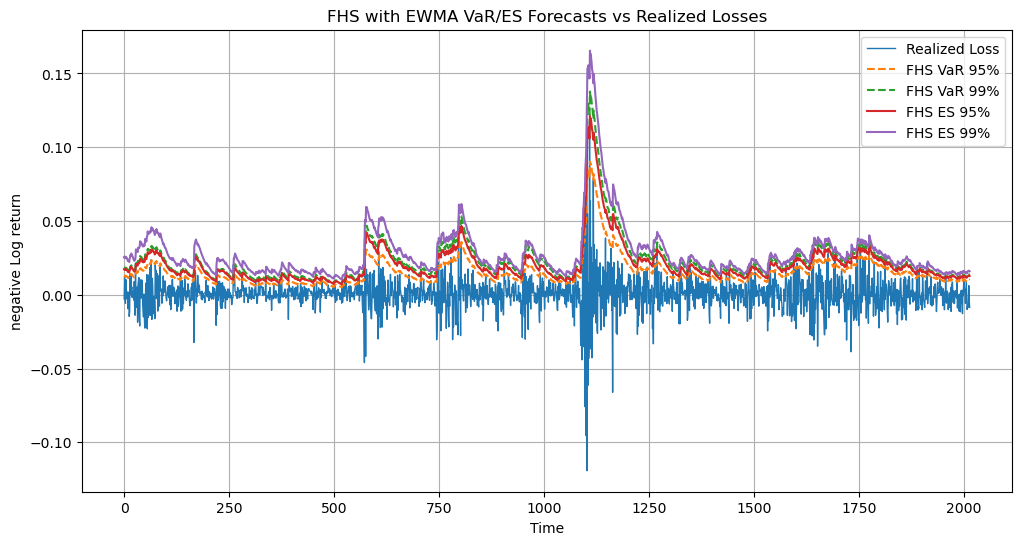

In [6]:
#Plot of results using HS
plt.figure(figsize=(12,6))

# Plot actual realized losses
plt.plot(result1.index, result1["realized_loss"], label="Realized Loss", linewidth=1)

# Plot HS VaR forecasts
plt.plot(result1.index, result1["FHS_VaR_95"], label="FHS VaR 95%", linestyle="--")
plt.plot(result1.index, result1["FHS_VaR_99"], label="FHS VaR 99%", linestyle="--")

# Plot HS ES forecasts
plt.plot(result1.index, result1["FHS_ES_95"], label="FHS ES 95%", linestyle="-")
plt.plot(result1.index, result1["FHS_ES_99"], label="FHS ES 99%", linestyle="-")

plt.title("FHS with EWMA VaR/ES Forecasts vs Realized Losses")
plt.xlabel("Time")
plt.ylabel("negative Log return")
plt.legend()
plt.grid(True)
plt.show()


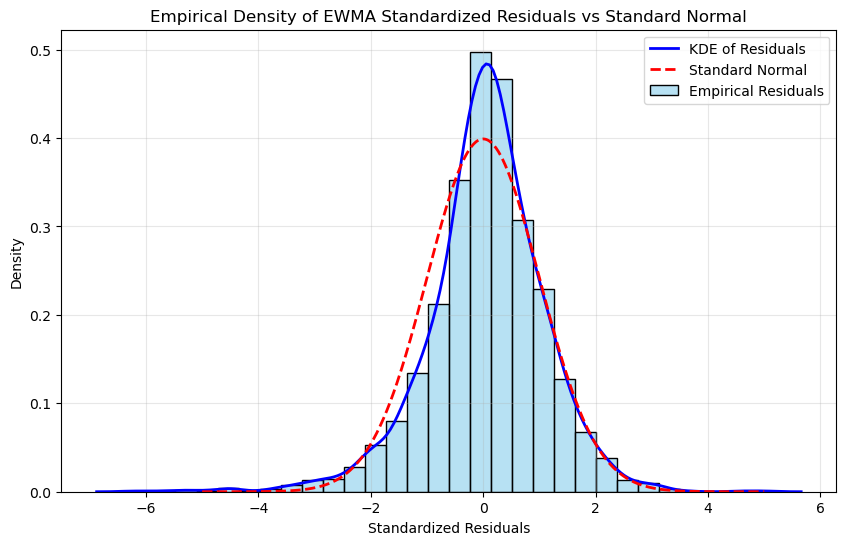

In [21]:
#Plot standardised residuals of EWMA
plt.figure(figsize=(10,6))

# Histogram
sns.histplot(residuals, bins=30, kde=False, stat='density', color='skyblue', alpha=0.6, label='Empirical Residuals')

# Kernel density estimate
sns.kdeplot(residuals, color='blue', lw=2, label='KDE of Residuals')

# Standard normal density
x = np.linspace(-5, 5, 500)
plt.plot(x, norm.pdf(x, 0, 1), 'r--', lw=2, label='Standard Normal')

plt.title('Empirical Density of EWMA Standardized Residuals vs Standard Normal')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [7]:
#Implementation of FHS with GARCH method
results2 = []

for i in range(500, len(df1)-1):
    # Use the previous 500 returns for estimation window
    window1 = loss.iloc[i-500:i]
    # Fit GARCH(1,1) with constant mean, normal innovations
    am = arch_model(window1, mean="Constant", vol="Garch", p=1, q=1, dist="normal",rescale=False)
    res = am.fit(disp="off")
    # 1-step ahead forecast of conditional variance
    forecast = res.forecast(horizon=1, reindex=False)
    # Using the mean and variance forecast for next day
    vol1 = forecast.variance.values[-1, 0]
    sigma1 = np.sqrt(vol1)
    mu = forecast.mean.iloc[-1].values[0]
    # Find the 500 standardized residuals Z_t
    Z_t2 = res.std_resid
    # Compute quantiles of standardised residual
    z_95 =np.quantile(Z_t2, 0.95)
    z_99 = np.quantile(Z_t2, 0.99)
    VaR95 = mu+sigma1*z_95
    VaR99 = mu+sigma1*z_99
    ES95 = sigma1*Z_t2[Z_t2 >= z_95].mean()
    ES99 = sigma1*Z_t2[Z_t2 >= z_99].mean()
    results2.append({"FHS-GARCH_VaR_95": VaR95,"FHS-GARCH_ES_95": ES95,"FHS-GARCH_VaR_99": VaR99,
                     "FHS-GARCH_ES_99": ES99,"realized_loss": loss[i]})
results2= pd.DataFrame(results2)

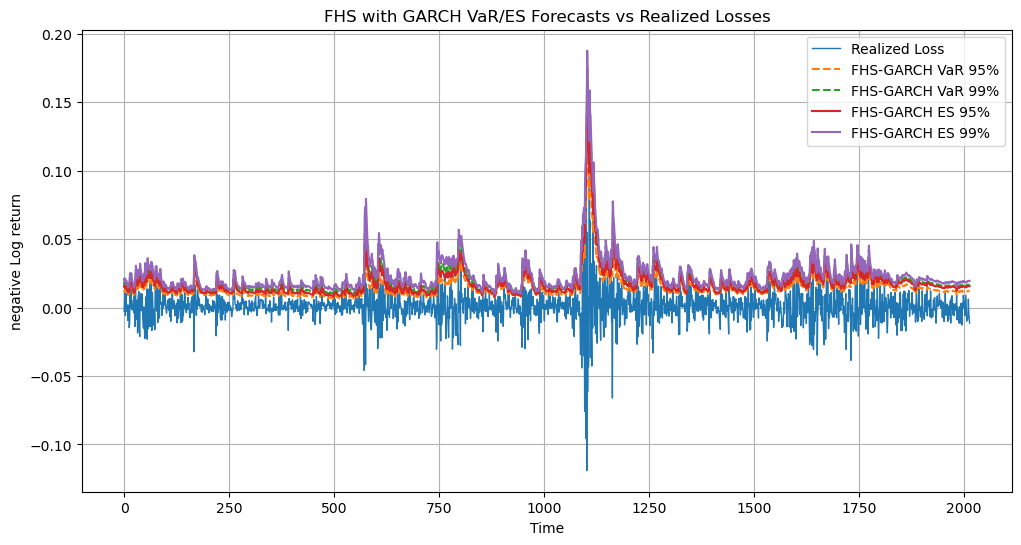

In [8]:
#Plot of results using HS
plt.figure(figsize=(12,6))

# Plot actual realized losses
plt.plot(results2.index, results2["realized_loss"], label="Realized Loss", linewidth=1)

# Plot HS VaR forecasts
plt.plot(results2.index, results2["FHS-GARCH_VaR_95"], label="FHS-GARCH VaR 95%", linestyle="--")
plt.plot(results2.index, results2["FHS-GARCH_VaR_99"], label="FHS-GARCH VaR 99%", linestyle="--")

# Plot HS ES forecasts
plt.plot(results2.index, results2["FHS-GARCH_ES_95"], label="FHS-GARCH ES 95%", linestyle="-")
plt.plot(results2.index, results2["FHS-GARCH_ES_99"], label="FHS-GARCH ES 99%", linestyle="-")

plt.title("FHS with GARCH VaR/ES Forecasts vs Realized Losses")
plt.xlabel("Time")
plt.ylabel("negative Log return")
plt.legend()
plt.grid(True)
plt.show()

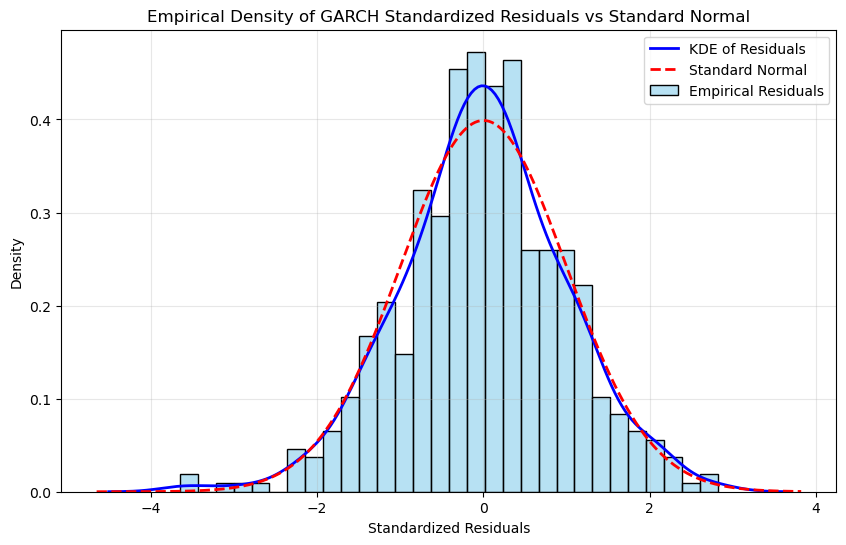

In [22]:
#Plot of GARCH standardised residual
plt.figure(figsize=(10,6))

# Histogram
sns.histplot(Z_t2, bins=30, kde=False, stat='density', color='skyblue', alpha=0.6, label='Empirical Residuals')

# Kernel density estimate
sns.kdeplot(Z_t2, color='blue', lw=2, label='KDE of Residuals')

# Standard normal density
x = np.linspace(Z_t2.min()-1, Z_t2.max()+1, 500)
plt.plot(x, norm.pdf(x, 0, 1), 'r--', lw=2, label='Standard Normal')

plt.title('Empirical Density of GARCH Standardized Residuals vs Standard Normal')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [9]:
#The unconditional VaR test
def unconditional(violations, alpha):
    T = len(violations)
    #Find the number of violations
    x = sum(violations)
    pi = x / T
    # Likelihood ratio
    LRuc = -2 * (np.log((1 - alpha) ** (T - x) * alpha ** x) -np.log((1 - pi) ** (T - x) * pi ** x))
    p_value = 1 - chi2.cdf(LRuc, df=1)
    return LRuc, p_value, pi
#Test for independence of violations
def independence_test(violations):
    # Transition counts
    n00 = ((violations == False) & (violations.shift(-1) == False)).sum()
    n01 = ((violations == False) & (violations.shift(-1) == True)).sum()
    n10 = ((violations == True) & (violations.shift(-1) == False)).sum()
    n11 = ((violations == True) & (violations.shift(-1) == True)).sum()

    # Markov transition probabilities
    pi0 = n01 / (n00 + n01)
    pi1 = n11 / (n10 + n11)
    pi  = (n01 + n11) / (n00 + n01 + n10 + n11)

    # Christoffersen independence LR statistic
    LRind = 2 * np.log(((1 - pi0)**n00 *(pi0)**n01 *(1 - pi1)**n10 *(pi1)**n11) /
                        ((1 - pi)**(n00 + n10) * (pi)**(n01 + n11)))
    p_value = 1 - chi2.cdf(LRind, df=1)
    return LRind, p_value
#Function for joint test
def joint_test(violations, alpha):
    LRuc, p_uc, pi = unconditional(violations, alpha)
    LRind, p_ind = independence_test(violations)
    LRcc = LRuc + LRind
    p_cc = 1 - chi2.cdf(LRcc, df=2)
    return LRcc, p_cc

In [10]:
#Backtest for the 95% VaR of HS method
violation_HS_95=result["realized_loss"]>result["HS_VaR_95"]
LRuc, p_uc, pi = unconditional(violation_HS_95, 0.05)
LRind, p_ind = independence_test(violation_HS_95)
LRcc, p_cc = joint_test(violation_HS_95, 0.05)

#Backtest for the 99% VaR of HS method
violation_HS_99=result["realized_loss"]>result["HS_VaR_99"]
LRuc1, p_uc1, pi1 = unconditional(violation_HS_99, 0.01)
LRind1, p_ind1 = independence_test(violation_HS_99)
LRcc1, p_cc1 = joint_test(violation_HS_99, 0.01)

In [11]:
#Backtest for the 95% VaR of FHS with EWMA method
violation_FHS_95=result1["realized_loss"]>result1["FHS_VaR_95"]
LRuc2, p_uc2, pi2 = unconditional(violation_FHS_95, 0.05)
LRind2, p_ind2 = independence_test(violation_FHS_95)
LRcc2, p_cc2 = joint_test(violation_FHS_95, 0.05)

#Backtest for the 99% VaR of FHS with EWMA method
violation_FHS_99=result1["realized_loss"]>result1["FHS_VaR_99"]
LRuc3, p_uc3, pi3 = unconditional(violation_FHS_99, 0.01)
LRind3, p_ind3 = independence_test(violation_FHS_99)
LRcc3, p_cc3 = joint_test(violation_FHS_99, 0.01)

In [12]:
#Backtest for the 95% VaR of FHS with GARCH method
violation_GFHS_95=results2["realized_loss"]>results2["FHS-GARCH_VaR_95"]
LRuc4, p_uc4, pi4 = unconditional(violation_GFHS_95, 0.05)
LRind4, p_ind4 = independence_test(violation_GFHS_95)
LRcc4, p_cc4 = joint_test(violation_GFHS_95, 0.05)

#Backtest for the 99% VaR of FHS with GARCH method
violation_GFHS_99=results2["realized_loss"]>results2["FHS-GARCH_VaR_99"]
LRuc5, p_uc5, pi5 = unconditional(violation_GFHS_99, 0.01)
LRind5, p_ind5 = independence_test(violation_GFHS_99)
LRcc5, p_cc5 = joint_test(violation_GFHS_99, 0.01)

In [13]:
#Create a data frame for backtest VaR result
VaR_backtest = pd.DataFrame({"HS_VaR95": {"Uncon": LRuc, "p_uc": p_uc,"Independent": LRind,
                                          "p_it": p_ind,"Joint": LRcc, "p_jt": p_cc},
                          "HS_VaR99": {"Uncon": LRuc1, "p_uc": p_uc1,"Independent": LRind1,
                                          "p_it": p_ind1,"Joint": LRcc1, "p_jt": p_cc1},
                          "FHS_EWMA_VaR95": {"Uncon": LRuc2, "p_uc": p_uc2,"Independent": LRind2,
                                          "p_it": p_ind2,"Joint": LRcc2, "p_jt": p_cc2},
                          "FHS_EWMA_VaR99": {"Uncon": LRuc3, "p_uc": p_uc3,"Independent": LRind3, 
                                          "p_it": p_ind3,"Joint": LRcc3, "p_jt": p_cc3},
                          "FHS_GARCH_VaR95": {"Uncon": LRuc4, "p_uc": p_uc4,"Independent": LRind4,
                                          "p_it": p_ind4,"Joint": LRcc4, "p_jt": p_cc4},
                          "FHS_GARCH_VaR99": {"Uncon": LRuc5, "p_uc": p_uc5,"Independent": LRind5,
                                          "p_it": p_ind5,"Joint": LRcc5, "p_jt": p_cc5}}).T
print(VaR_backtest)

                    Uncon      p_uc  Independent      p_it     Joint      p_jt
HS_VaR95         0.030372  0.861649     4.716550  0.029874  4.746922  0.093158
HS_VaR99         4.238210  0.039524     3.054093  0.080534  7.292303  0.026091
FHS_EWMA_VaR95   0.234395  0.628284     0.675812  0.411033  0.910207  0.634382
FHS_EWMA_VaR99   0.168457  0.681487     0.486198  0.485628  0.654654  0.720848
FHS_GARCH_VaR95  0.052524  0.818728     5.589540  0.018068  5.642064  0.059544
FHS_GARCH_VaR99  2.754944  0.096954     0.789553  0.374235  3.544497  0.169950


In [14]:
#Function for backtest ES for different model
def es_backtest(loss, var, es):
    #Indicator function for whether the loss exceeding the VaR
    I = (loss > var).astype(float)
    # value of loss compared to ES forecast
    ex1 = (loss - es) * I
    sum_ex1  = np.sum(ex1)
    sum_ex2 = np.sum(ex1**2)
    #Standard normal test statistics
    Z = sum_ex1 / np.sqrt(sum_ex2)
    #  p-value
    p = 2 * (1 - norm.cdf(abs(Z)))
    return {'Test Statistics': Z,'p-value': p}

In [15]:
#Create a data frame for backtest ES result
ES_backtest = pd.DataFrame({"HS_ES_95": es_backtest(result["realized_loss"],result["HS_VaR_95"],result["HS_ES_95"]),
                      "HS__ES_99": es_backtest(result["realized_loss"],result["HS_VaR_99"],result["HS_ES_99"]),
                      "FHS_EWMA_ES_95": es_backtest(result1["realized_loss"],result1["FHS_VaR_95"],result1["FHS_ES_95"]),
                      "FHS_EWMA_ES_99": es_backtest(result1["realized_loss"],result1["FHS_VaR_99"],result1["FHS_ES_99"]),
                      "FHS_GARCH_ES_95": es_backtest(results2["realized_loss"],results2["FHS-GARCH_VaR_95"],results2["FHS-GARCH_ES_95"]),
                      "FHS_GARCH_ES_99": es_backtest(results2["realized_loss"],results2["FHS-GARCH_VaR_99"],results2["FHS-GARCH_ES_99"])}).T
print(ES_backtest)

                 Test Statistics   p-value
HS_ES_95                1.124804  0.260672
HS__ES_99               1.779569  0.075147
FHS_EWMA_ES_95         -0.099448  0.920783
FHS_EWMA_ES_99         -1.232024  0.217940
FHS_GARCH_ES_95         1.942693  0.052053
FHS_GARCH_ES_99         0.678610  0.497385
